The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


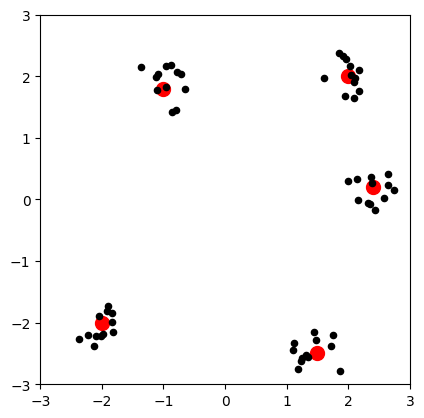

In [533]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from torch import Tensor
import torch
from mixture_of_gaussians import construct_isotropic_mog


pdf_cmap = "Oranges"

gen = torch.Generator()
gen.manual_seed(2)

# define centers, scales and counts for clouds
cloud_centers = [[2, 2], [-2, -2], [-1, 1.8], [2.4, 0.2], [1.5, -2.5]]
cloud_centers = Tensor(cloud_centers)
cloud_counts = [12] * len(cloud_centers)
cloud_scales = [0.4] * len(cloud_centers)

# construct points
cloud_points = []
for location, count, scale in zip(cloud_centers, cloud_counts, cloud_scales):
    cloud = torch.empty(count, 2).uniform_(-1, 1, generator=gen)
    cloud *= scale
    cloud += torch.tensor(location)
    cloud_points.append(cloud)


means = torch.cat(cloud_points)

bound = 3
plt.scatter(cloud_centers[:, 0], cloud_centers[:, 1], c="red", s=100)
plt.scatter(means[:, 0], means[:, 1], c="black", s=20)

plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.gca().set_aspect("equal", adjustable="box")

([], [])

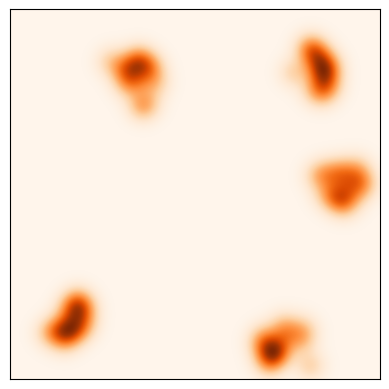

In [627]:
# construct MoG
scale = 0.03
scales = torch.Tensor([scale] * len(means))

weights = torch.Tensor([1] * len(means))
weights = weights / weights.sum()
mog = construct_isotropic_mog(weights, means, scales)

bound = 3
N = 1000

xs = torch.linspace(-bound, bound, N)
ys = torch.linspace(-bound, bound, N)
X, Y = torch.meshgrid(xs, ys, indexing="xy")
coords = torch.stack([X, Y], dim=-1)
pdf = mog.log_prob(coords).exp()

plt.imshow(pdf, extent=(-bound, bound, -bound, bound), origin="lower", cmap=pdf_cmap)
plt.xticks([])
plt.yticks([])

In [628]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0001,
    beta_end=0.02,
    clip_sample=False,
)

([], [])

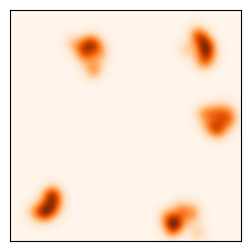

In [658]:
from ipython_utils import imshow_small
from mixture_of_gaussians import diffuse_mog

scale = 3
fig, ax = plt.subplots(figsize=(scale, scale))

t = reversed(scheduler.timesteps)[0]

# diffuse PDF
mog_diffused = diffuse_mog(mog, scheduler.alphas_cumprod, t)
pdf_diffused = mog_diffused.log_prob(coords).exp()

# plot pdf
pdf_imshow = ax.imshow(
    pdf_diffused, origin="lower", extent=(-bound, bound, -bound, bound), cmap=pdf_cmap
)

plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.xticks([])
plt.yticks([])

  6%|▌         | 6/100 [00:13<03:38,  2.33s/it]


  5%|▌         | 5/100 [00:06<01:43,  1.08s/it]

KeyboardInterrupt: 

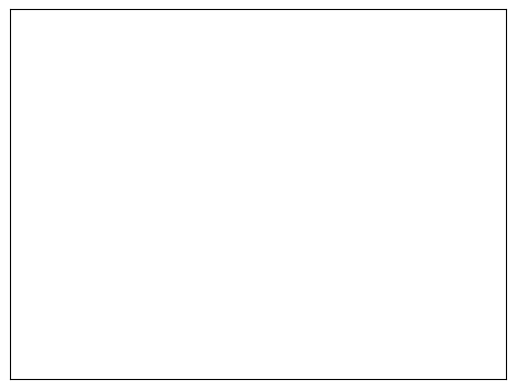

In [678]:
from matplotlib.animation import FFMpegWriter, FuncAnimation, PillowWriter
from tqdm import tqdm

from util import ordered_sample


def update(t):
    mog_diffused = diffuse_mog(mog, scheduler.alphas_cumprod, t)
    pdf_diffused = mog_diffused.log_prob(coords).exp()
    pdf_imshow.set_array(pdf_diffused)

    plt.xlim(-bound, bound)
    plt.ylim(-bound, bound)
    plt.xticks([])
    plt.yticks([])


timesteps = ordered_sample(scheduler.timesteps, 100)
timesteps = list(reversed(timesteps))

frames = timesteps
ani = FuncAnimation(fig, update, frames=frames, interval=100)

# writer = FFMpegWriter(
#     fps=10
# )

pbar = tqdm(total=len(frames))
ani.save(
    "diffusion.gif",
    fps=10,
    writer="imagemagick",
    progress_callback=lambda i, n: pbar.update(1),
)

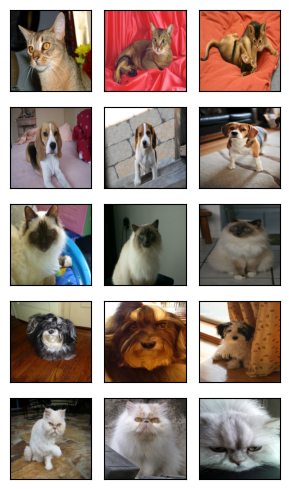

In [559]:
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.functional as TF
from ipython_utils import display_ims_grid

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Load image dataset
dataset = OxfordIIITPet(
    root="data",
    split="trainval",
    target_types="category",
    download=True,
    transform=transform,
)

cloud_images = [
    [8, 6, 4],
    [203, 201, 202],
    [300, 301, 302],
    [800, 801, 802],
    [3000, 3001, 3002],
]

images = []
for indices in cloud_images:
    cloud_ims = [TF.to_pil_image(dataset[i][0]) for i in indices]
    images.append(cloud_ims)

display_ims_grid(images, scale=1)
# display_ims(images)

In [567]:
category_cloud_indices = [0, 1, 2, 3, 4, 5]

image_coords = [
    cloud_points[i][0 : len(im_indices)]
    for i, im_indices in zip(category_cloud_indices, cloud_images)
]
image_coords_flat = torch.cat(image_coords)

images = []
images_flat = []
for indices in cloud_images:
    cloud_ims = [TF.to_pil_image(dataset[i][0]) for i in indices]
    images.append(cloud_ims)
    images_flat.extend(cloud_ims)

([], [])

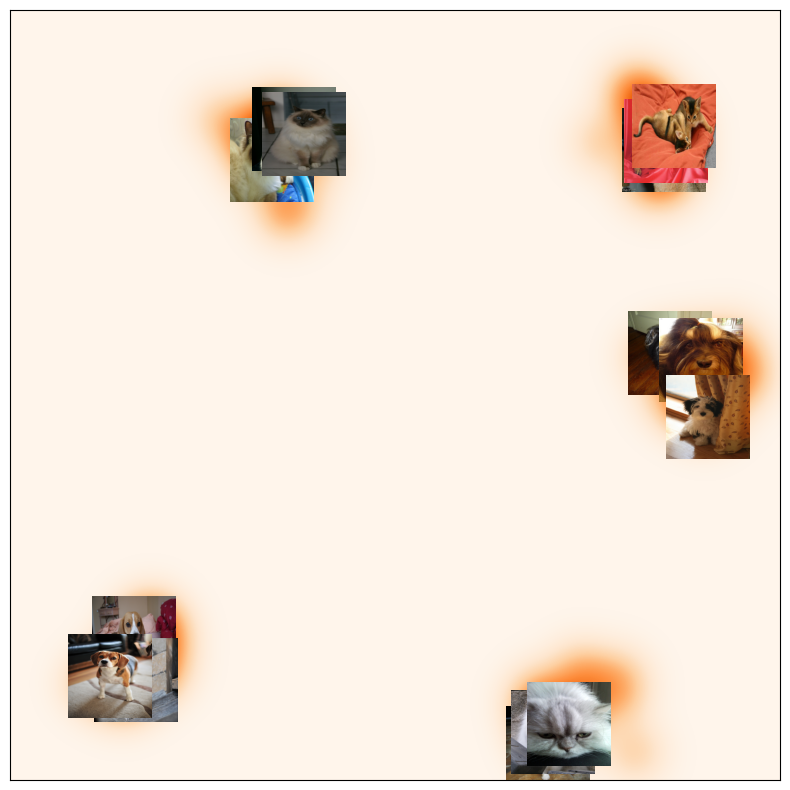

In [629]:
from ipython_utils import imshow_small

scale = 10
fig, ax = plt.subplots(figsize=(scale, scale))

# plot pdf
plt.imshow(pdf, origin="lower", extent=(-bound, bound, -bound, bound), cmap=pdf_cmap)

# plot images
for coord, im in zip(image_coords_flat, images_flat):
    imshow_small(im, coord)

plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.xticks([])
plt.yticks([])

([], [])

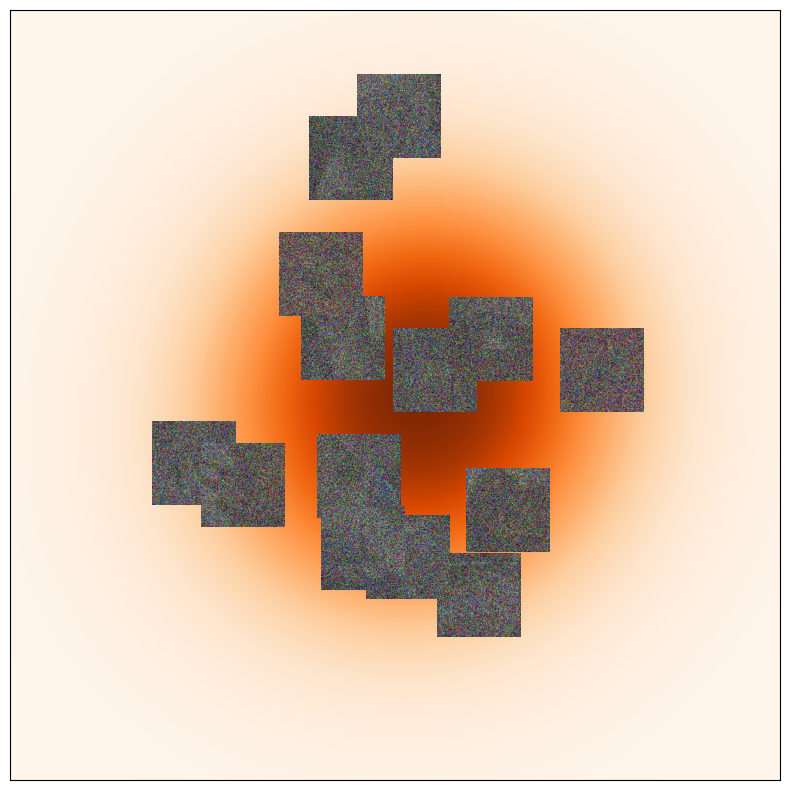

In [635]:
from ipython_utils import to_pil_image
from mixture_of_gaussians import diffuse_mog

t = reversed(scheduler.timesteps)[500]

# diffuse PDF
mog_diffused = diffuse_mog(mog, scheduler.alphas_cumprod, t)
pdf_diffused = mog_diffused.log_prob(coords).exp()

# diffuse image coordinates
diffused_image_coords = scheduler.add_noise(
    image_coords_flat, torch.randn_like(image_coords_flat), t
)

diffused_images = []
for im in images_flat:
    tensor_im = TF.to_tensor(im)
    diffused = scheduler.add_noise(tensor_im, torch.randn_like(tensor_im), t)
    diffused_images.append(to_pil_image(diffused, clip=True))

scale = 10
fig, ax = plt.subplots(figsize=(scale, scale))

plt.imshow(
    pdf_diffused, origin="lower", extent=(-bound, bound, -bound, bound), cmap=pdf_cmap
)

for coord, im in zip(diffused_image_coords, diffused_images):
    imshow_small(im, coord)

plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.xticks([])
plt.yticks([])

([], [])

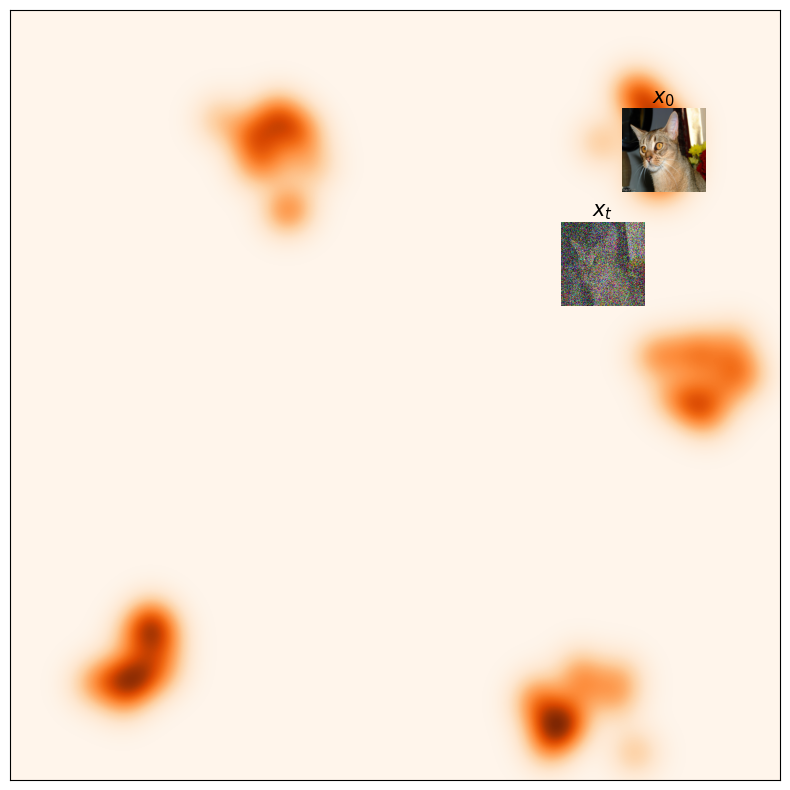

In [624]:
image_idx = 0

gen = torch.Generator()
gen.manual_seed(2)

image = images_flat[image_idx]
coord = image_coords_flat[image_idx]

t = reversed(scheduler.timesteps)[300]

# diffuse PDF
mog_diffused = diffuse_mog(mog, scheduler.alphas_cumprod, t)
pdf_diffused = mog_diffused.log_prob(coords).exp()

# noisify image
image_pt = TF.to_tensor(image)
noisy_pt = scheduler.add_noise(image_pt, torch.randn_like(image_pt), t)
noisy = to_pil_image(noisy_pt, clip=True)

# noisify coord
epsilon = torch.randn(coord.shape, generator=gen)
noisy_coord = scheduler.add_noise(coord, epsilon, t)

scale = 10
fig, ax = plt.subplots(figsize=(scale, scale))
plt.imshow(pdf, origin="lower", extent=(-bound, bound, -bound, bound), cmap=pdf_cmap)

imshow_small(image, coord, label="$x_0$")
imshow_small(noisy, noisy_coord, label="$x_t$")

plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.xticks([])
plt.yticks([])